In [1]:
require(data.table)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(DECIPHER)
require(RColorBrewer)
require(vegan)
require(phangorn)
require(ape)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dada2

Loading required package: Rcpp

Loading required package: phyloseq

Loading required package: genefilter

Loading required package: ggplot2

Loading required package: DECIPHER

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DECIPHER’”
Loading required package: RColorBrewer

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2

Loading required package: phangorn

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘phangorn’”
Loading required package: ape



In [2]:
meta=fread("~/Documents/DE/DE_16S/DE16S_allmeta.csv")
asv_all=fread("~/Documents/DE/DE_16S/ASVs/Run123_ASV_nochim.csv")
taxa=read.csv("~/Documents/DE/DE_16S/ASVs/Run123_taxa.csv", header=TRUE, row.names=1)

In [3]:
#fix rownames
rows=as.vector(asv_all[,1])
asv_all=asv_all[,-1]
asv_all=apply(asv_all, 2, as.numeric)
row.names(asv_all)=rows$V1

In [4]:
#negative controls 
negs=meta[meta$Experiment=="Negative",]
negcounts=asv_all[row.names(asv_all) %in% negs$UniqueID,]
negotucounts=negcounts[,colSums(negcounts)>0]
negotus=colnames(negotucounts)

In [5]:
taxa=as.matrix(taxa)
meta=as.data.frame(meta)
row.names(meta)=meta$UniqueID

In [6]:
OTU = otu_table(t(asv_all), taxa_are_rows = TRUE)
TAX = tax_table(taxa)
SAMP=sample_data(meta)

In [7]:
OTU=transform_sample_counts(OTU, function(x) 1E6 * x/sum(x))

In [8]:
#normalize and keep as percentages
OTU=transform_sample_counts(OTU, function(x) 100 * x/sum(x))

In [9]:
ALL = phyloseq(OTU, TAX, SAMP)

In [11]:
ALLCV=subset_samples(ALL, Species=="CV")


In [12]:
## normalized by sample
Spiro = subset_taxa(ALLCV, Phylum=="Spirochaetota")

In [29]:
Spiro_50 = prune_taxa(names(sort(taxa_sums(Spiro),TRUE)[1:10]), Spiro)


In [30]:
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(10)

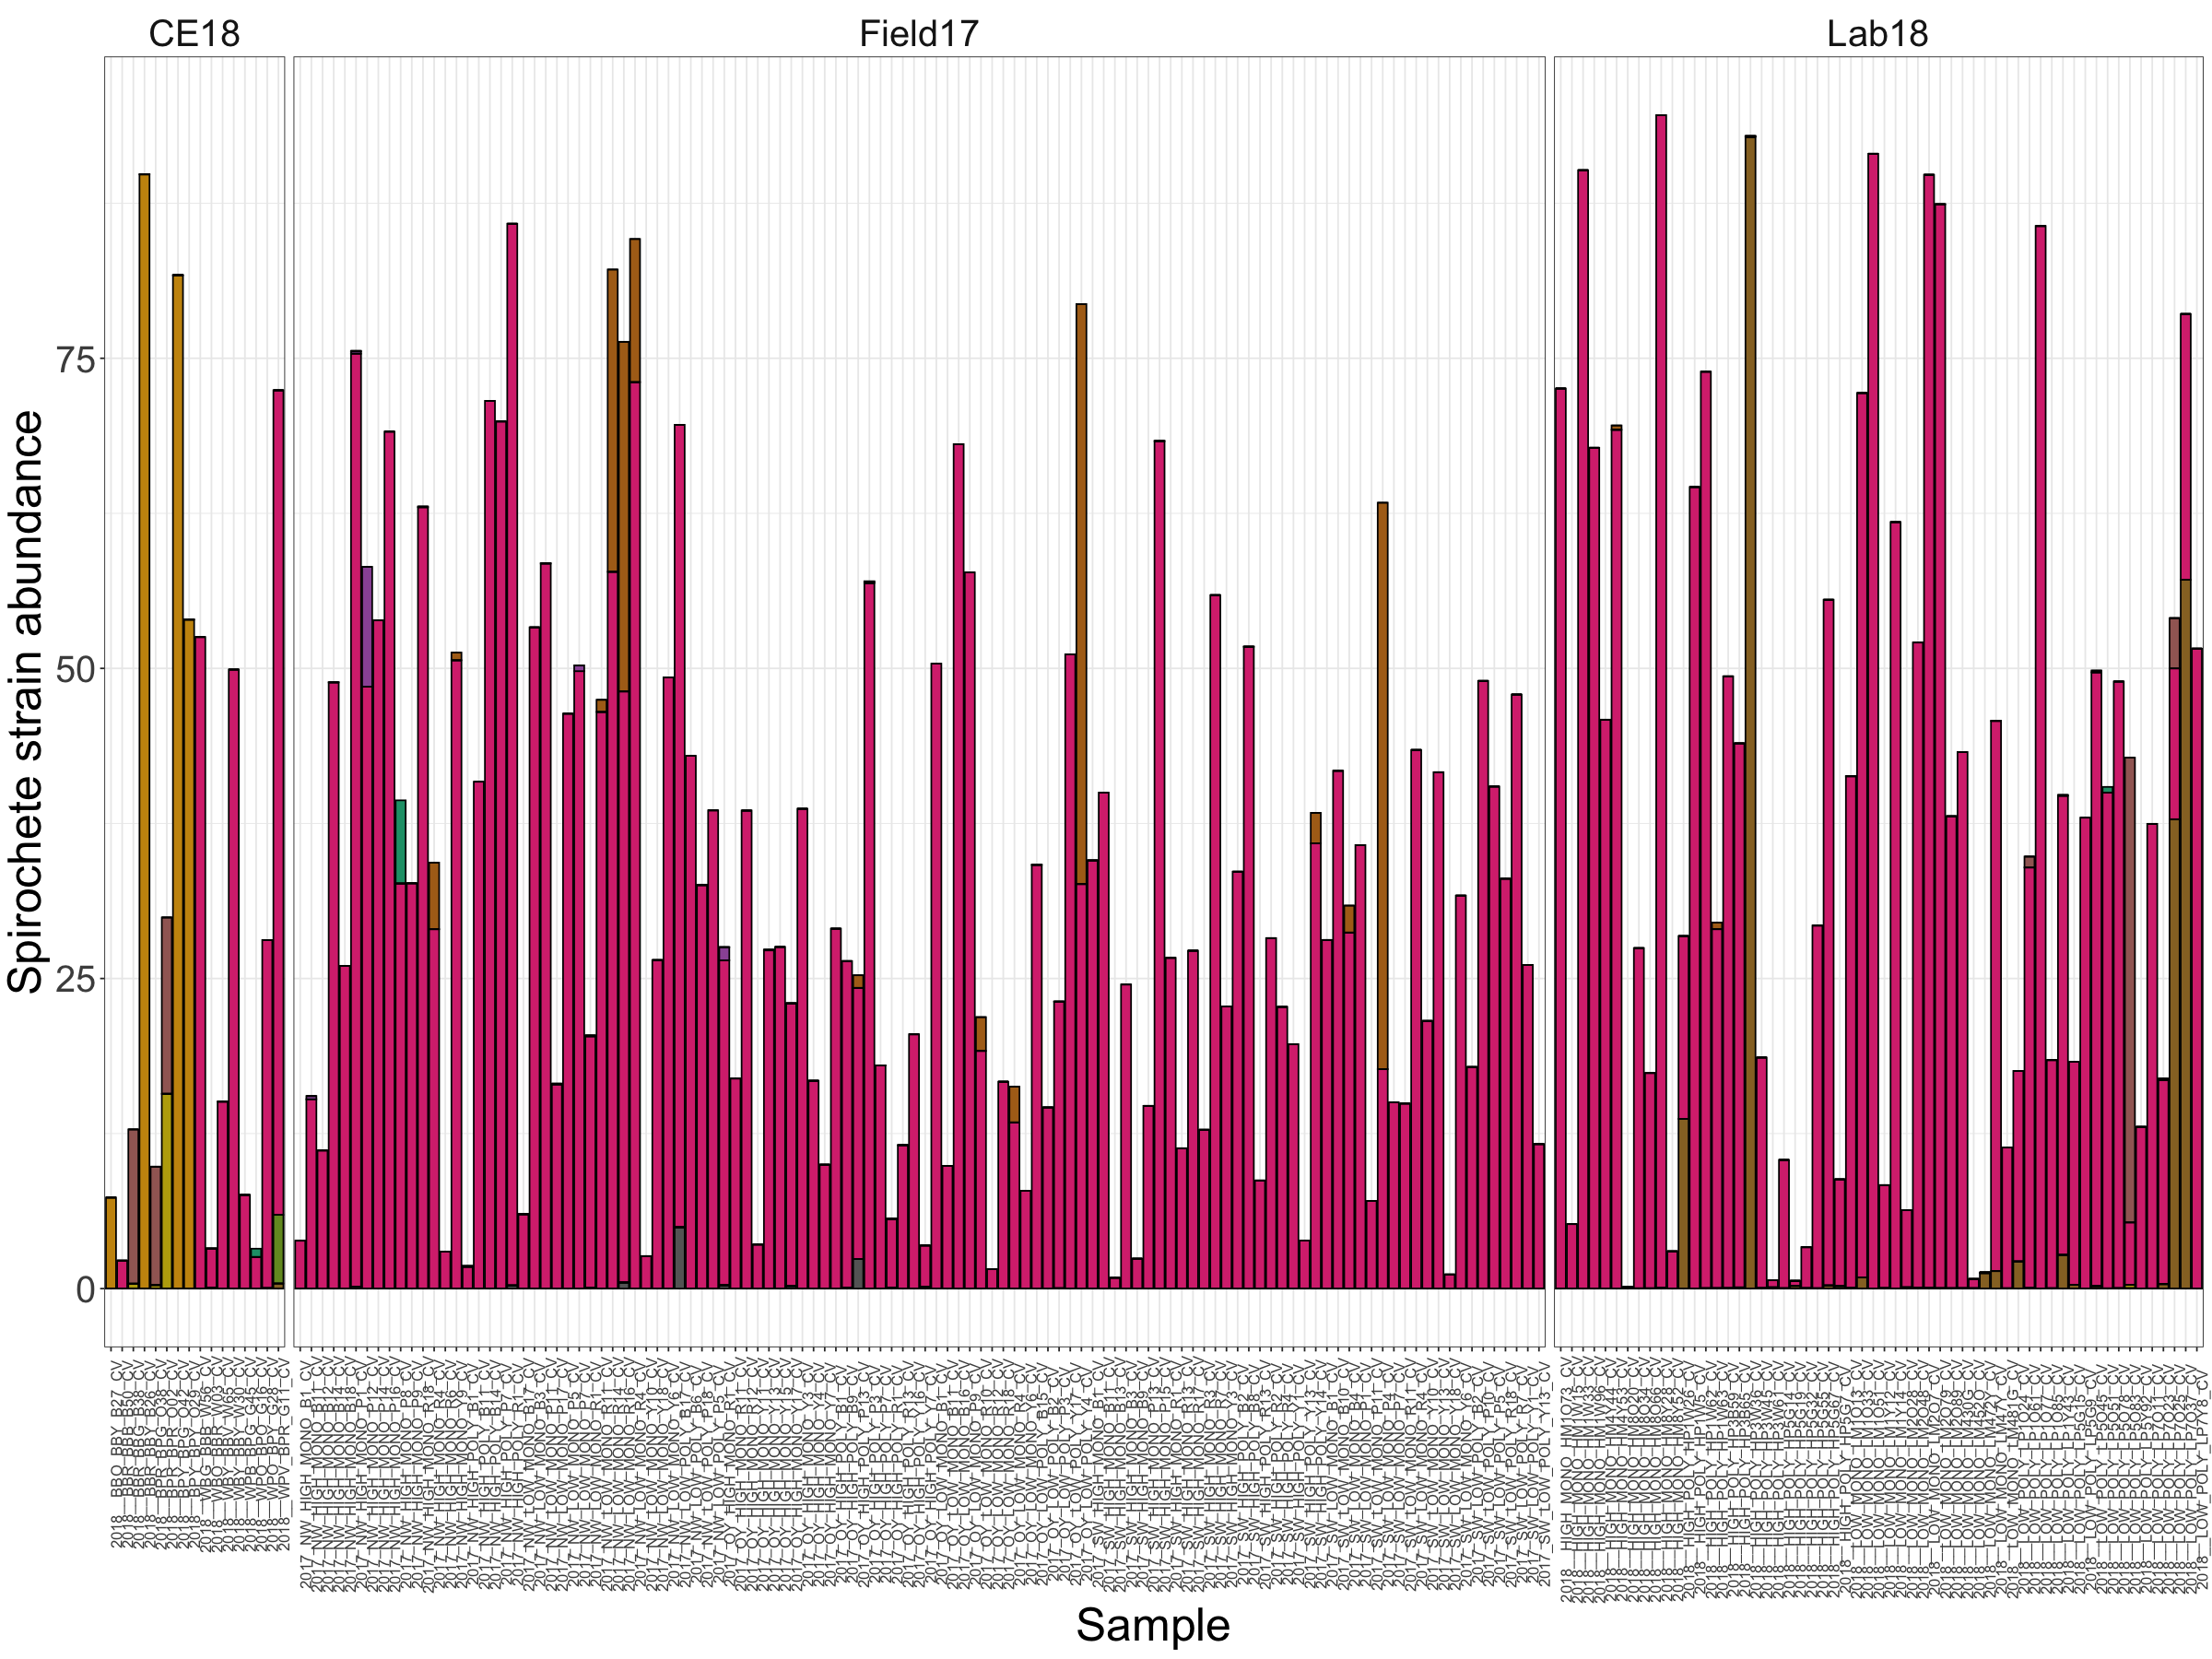

In [31]:
plot_bar(Spiro_50, fill="OTU")+
scale_fill_manual(values=mycolors)+
theme_bw()+
facet_grid(.~Experiment, scales="free_x", space="free_x")+
 ylab("Spirochete strain abundance")+
theme(legend.position = "none",  text = element_text(size=30), axis.text.x = element_text(angle=90, size=10), strip.background = element_blank())


In [ ]:
plot_bar(Spiro, fill="OTU")+
scale_fill_manual(values=mycolors)+
theme(legend.position = "none")

Warning message:
“Removed 1260 rows containing missing values (position_stack).”


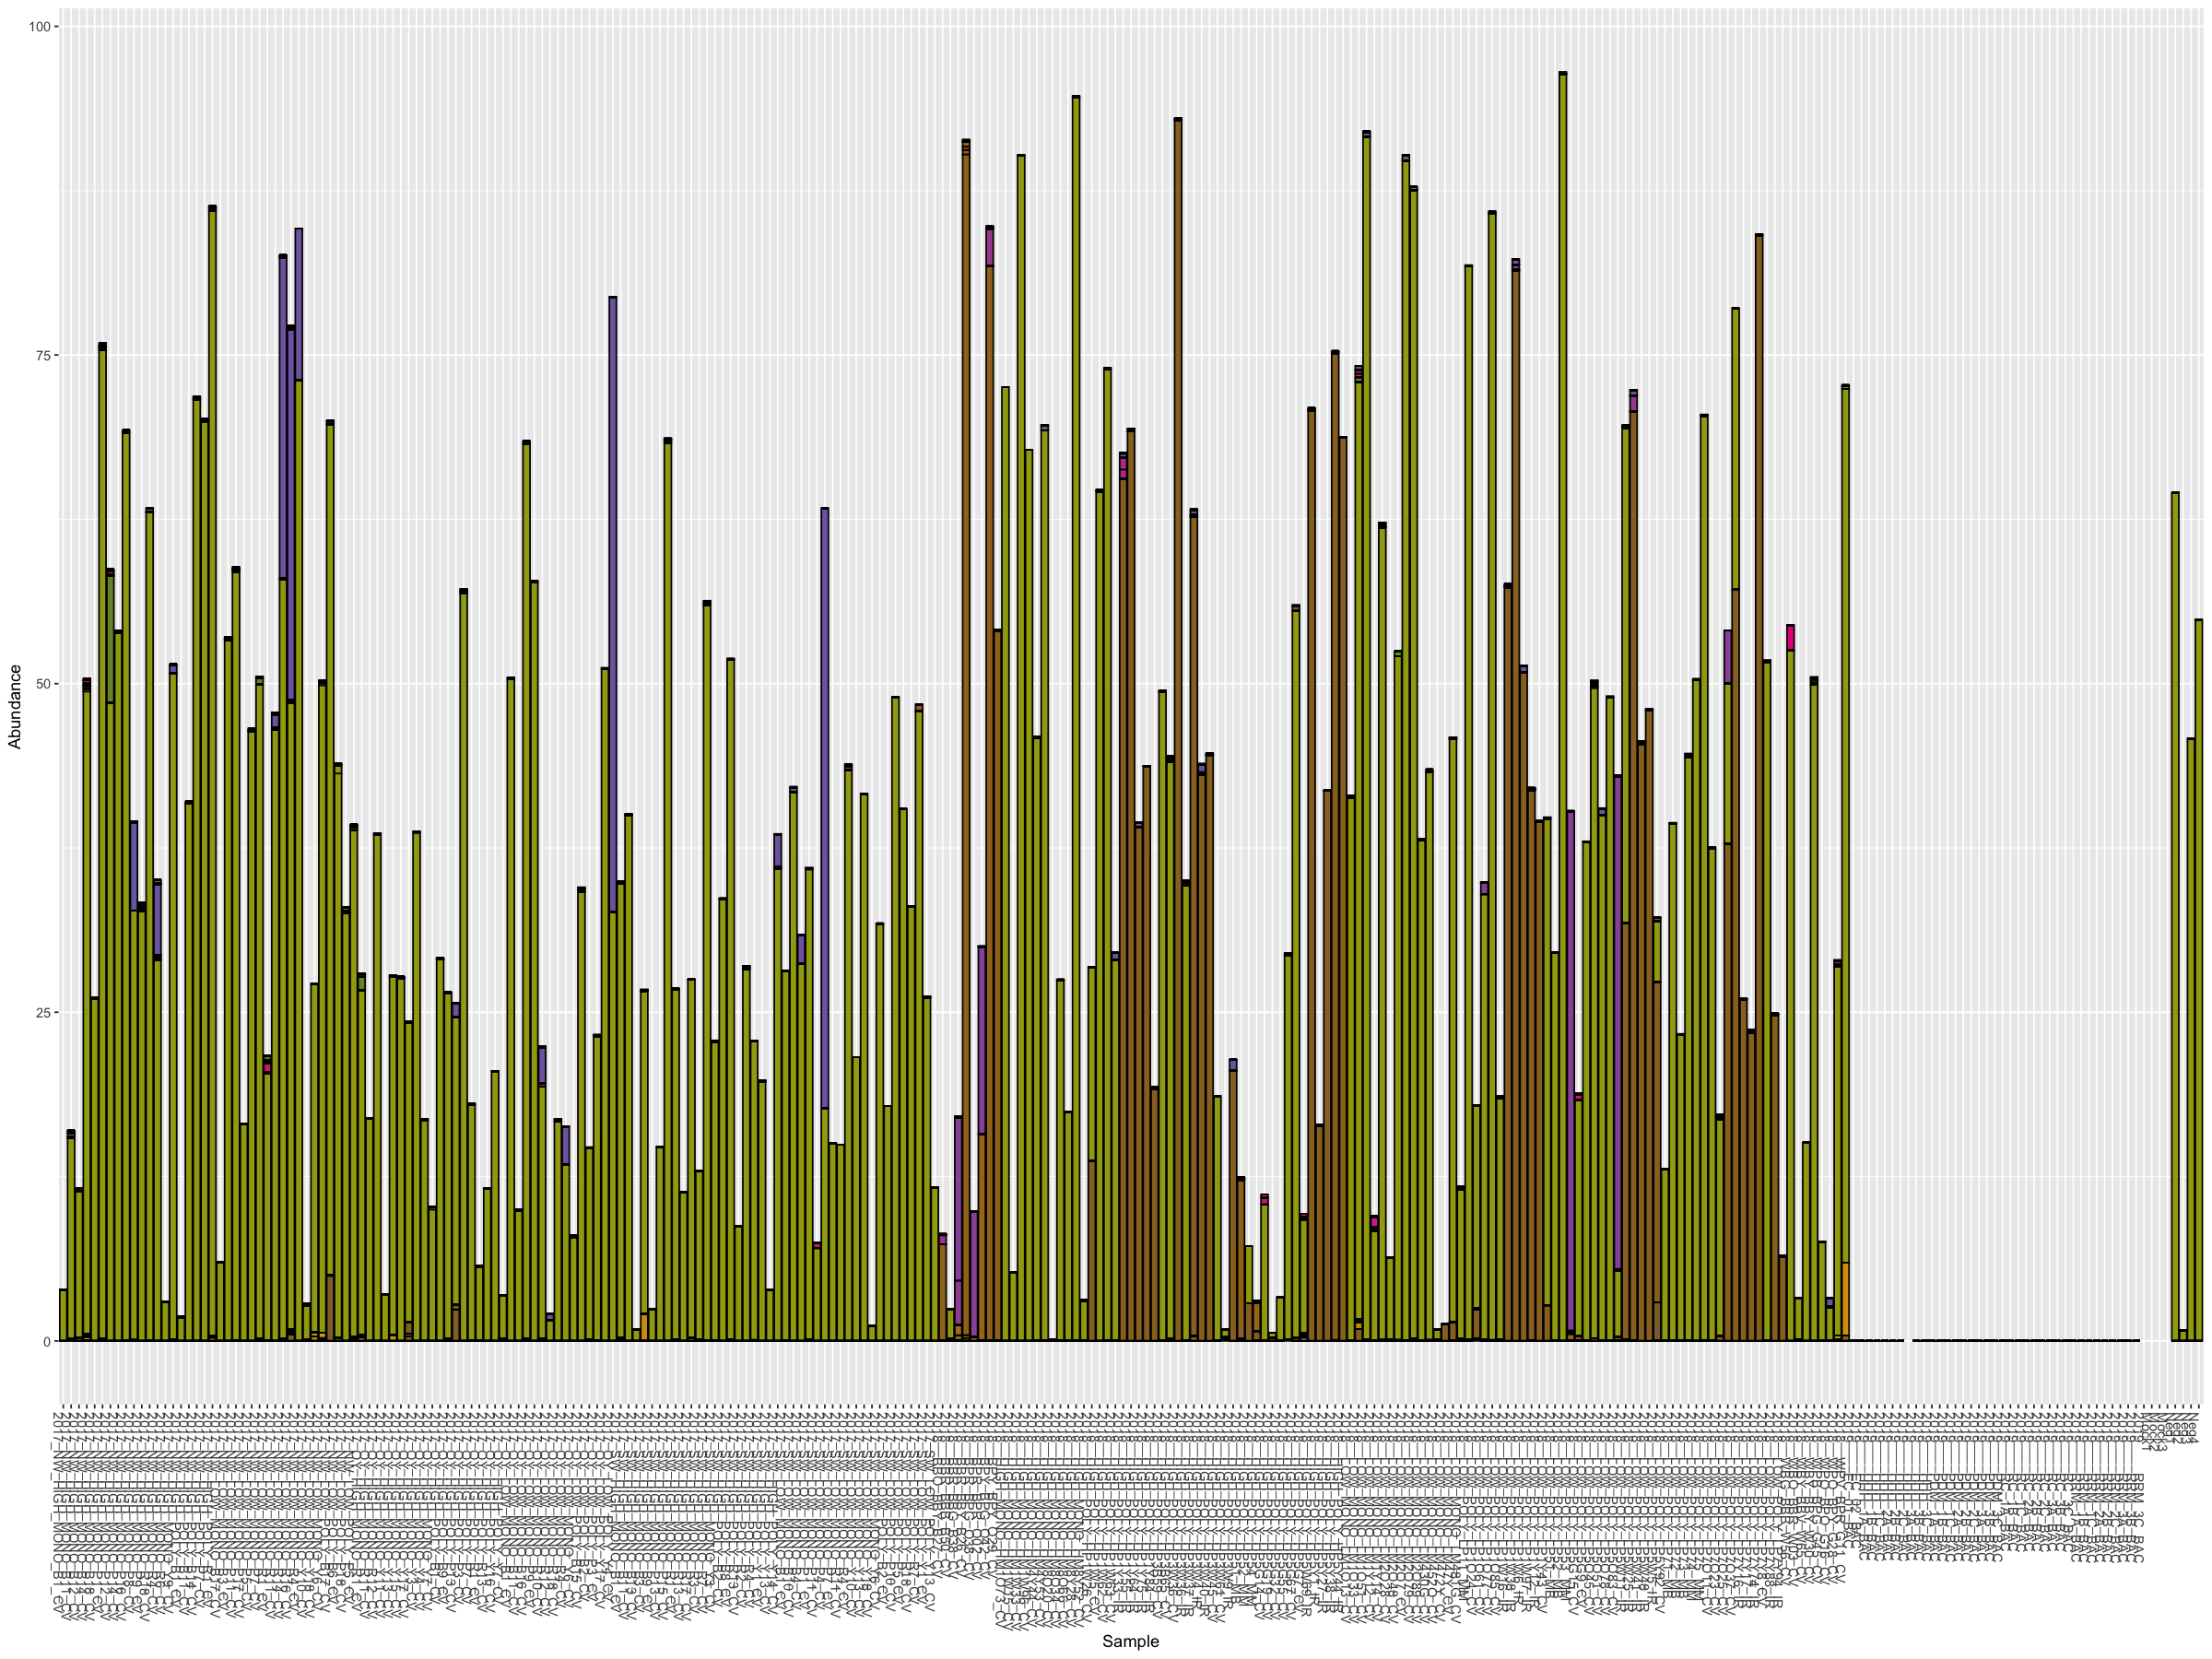

In [13]:
## not normalized by sample
Spiro = subset_taxa(ALL, Phylum=="Spirochaetota")
plot_bar(Spiro, fill="OTU")+
scale_fill_manual(values=mycolors)+
theme(legend.position = "none")

Warning message:
“Removed 1260 rows containing missing values (position_stack).”


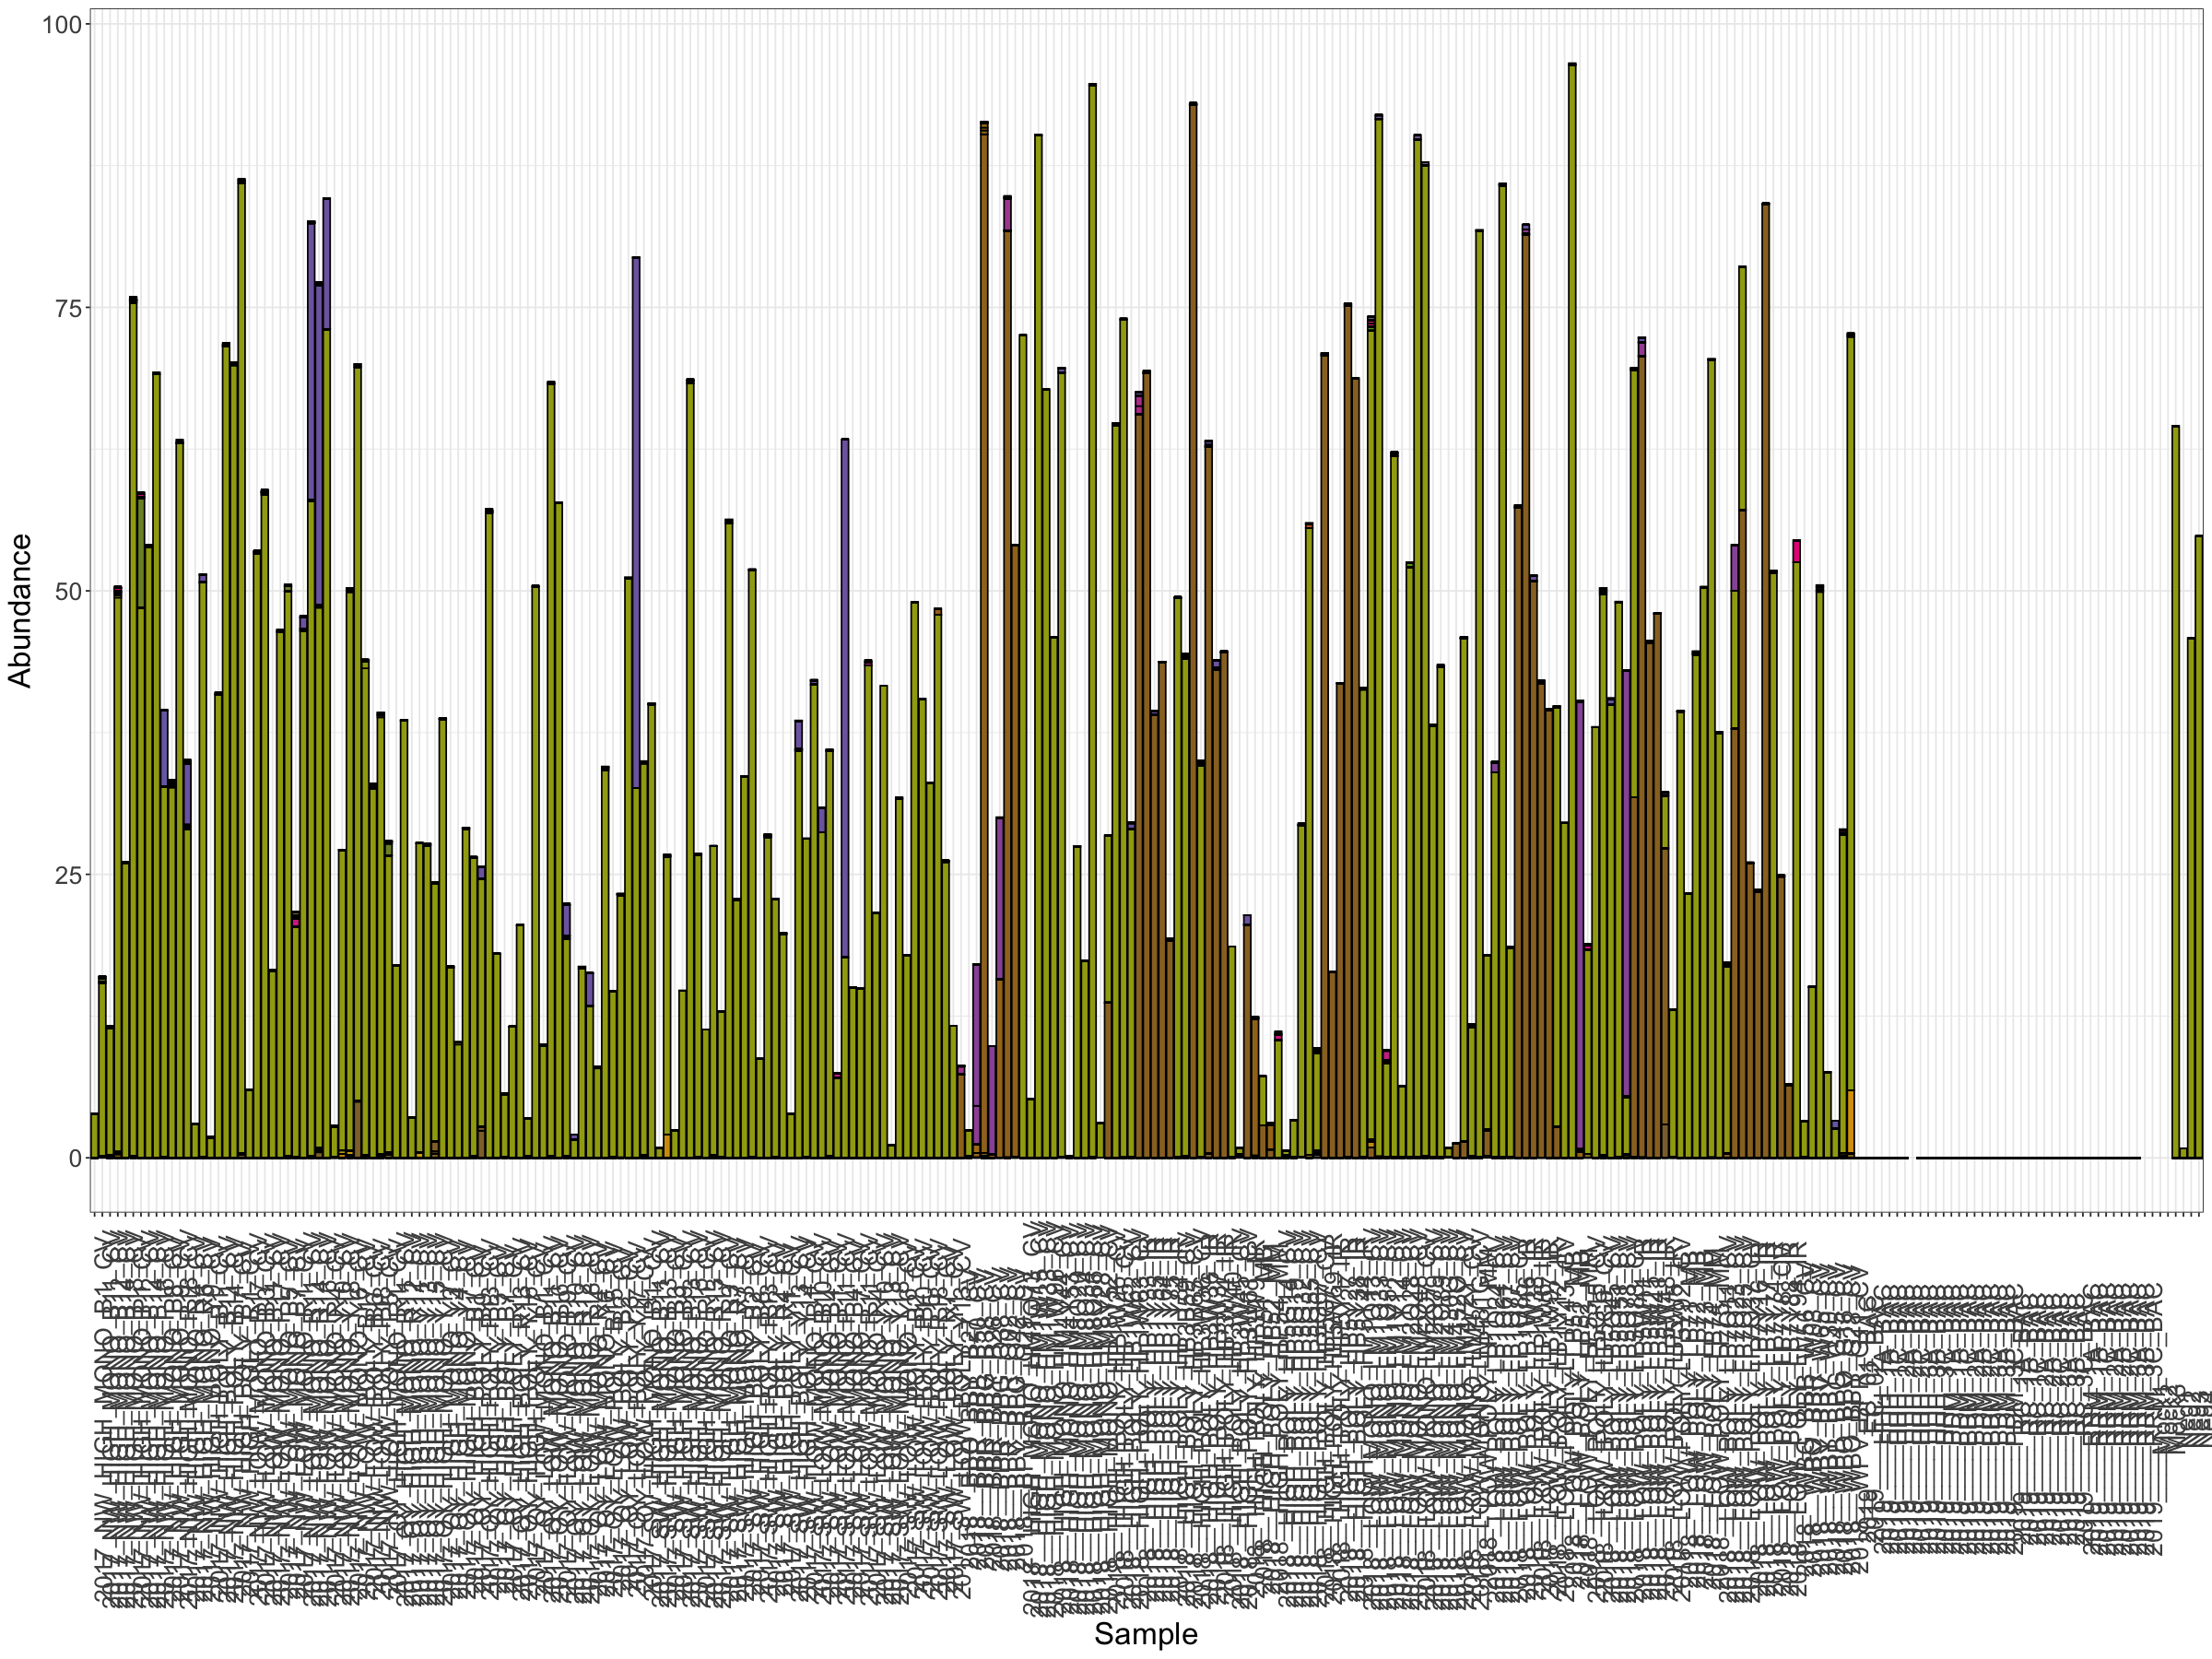

In [15]:
## Percentages of samples
Spiro = subset_taxa(ALL, Phylum=="Spirochaetota")
plot_bar(Spiro, fill="OTU")+
scale_fill_manual(values=mycolors)+
theme_bw()+
theme(legend.position = "none", text = element_text(size=20), axis.text.x = element_text(angle = 90))


In [61]:
seqs=taxa_names(Spiro)
names(seqs) = seqs

In [ ]:
alignment=AlignSeqs(DNAStringSet(seqs), anchor=NA)

In [63]:
phang.align = phyDat(as(alignment, "matrix"), type="DNA")

In [64]:
dm = dist.ml(phang.align)

In [65]:
treeNJ = NJ(dm) 


In [66]:
fit = pml(treeNJ, data=phang.align)

negative edges length changed to 0!



In [67]:
fitGTR <- update(fit, k=4, inv=0.2)

In [68]:
fitGTR <- optim.pml(fitGTR, model="GTR", optInv=TRUE, optGamma=TRUE,
                    rearrangement = "stochastic", control = pml.control(trace = 0))

In [79]:
Spiro = merge_phyloseq(Spiro, treeNJ)


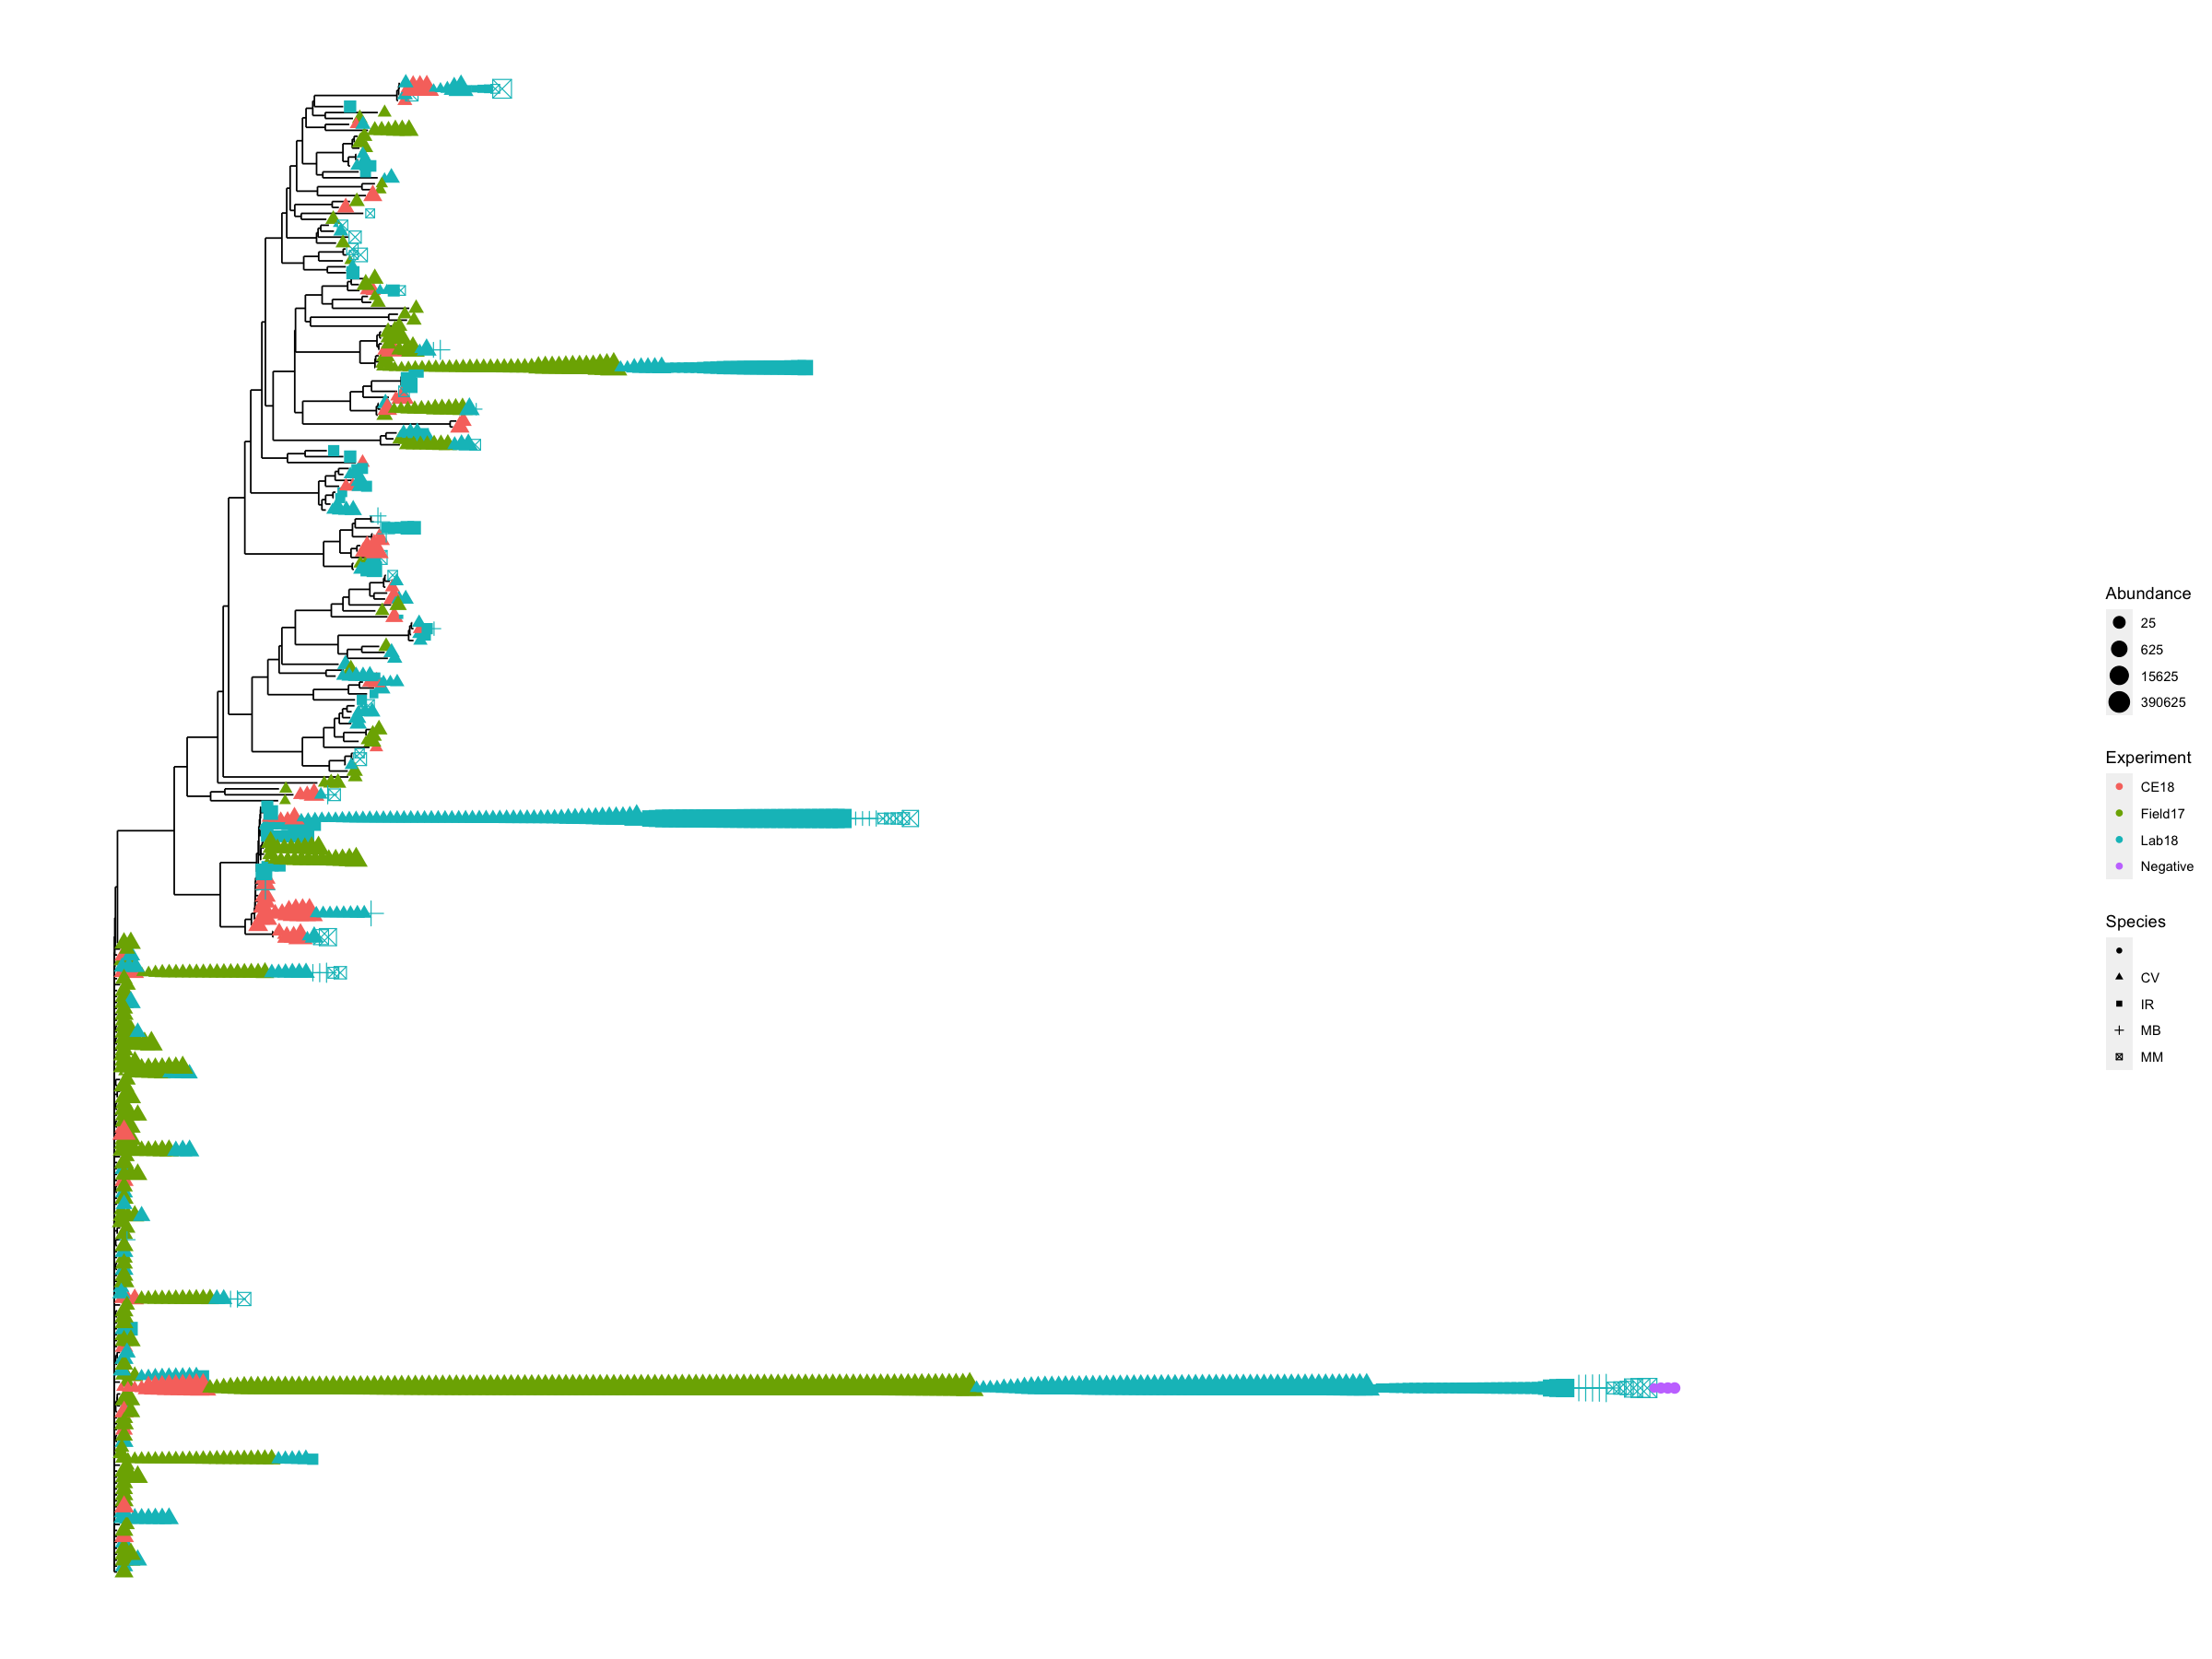

In [80]:
plot_tree(Spiro, color = "Experiment", shape = "Species", ladderize="left", size="abundance")

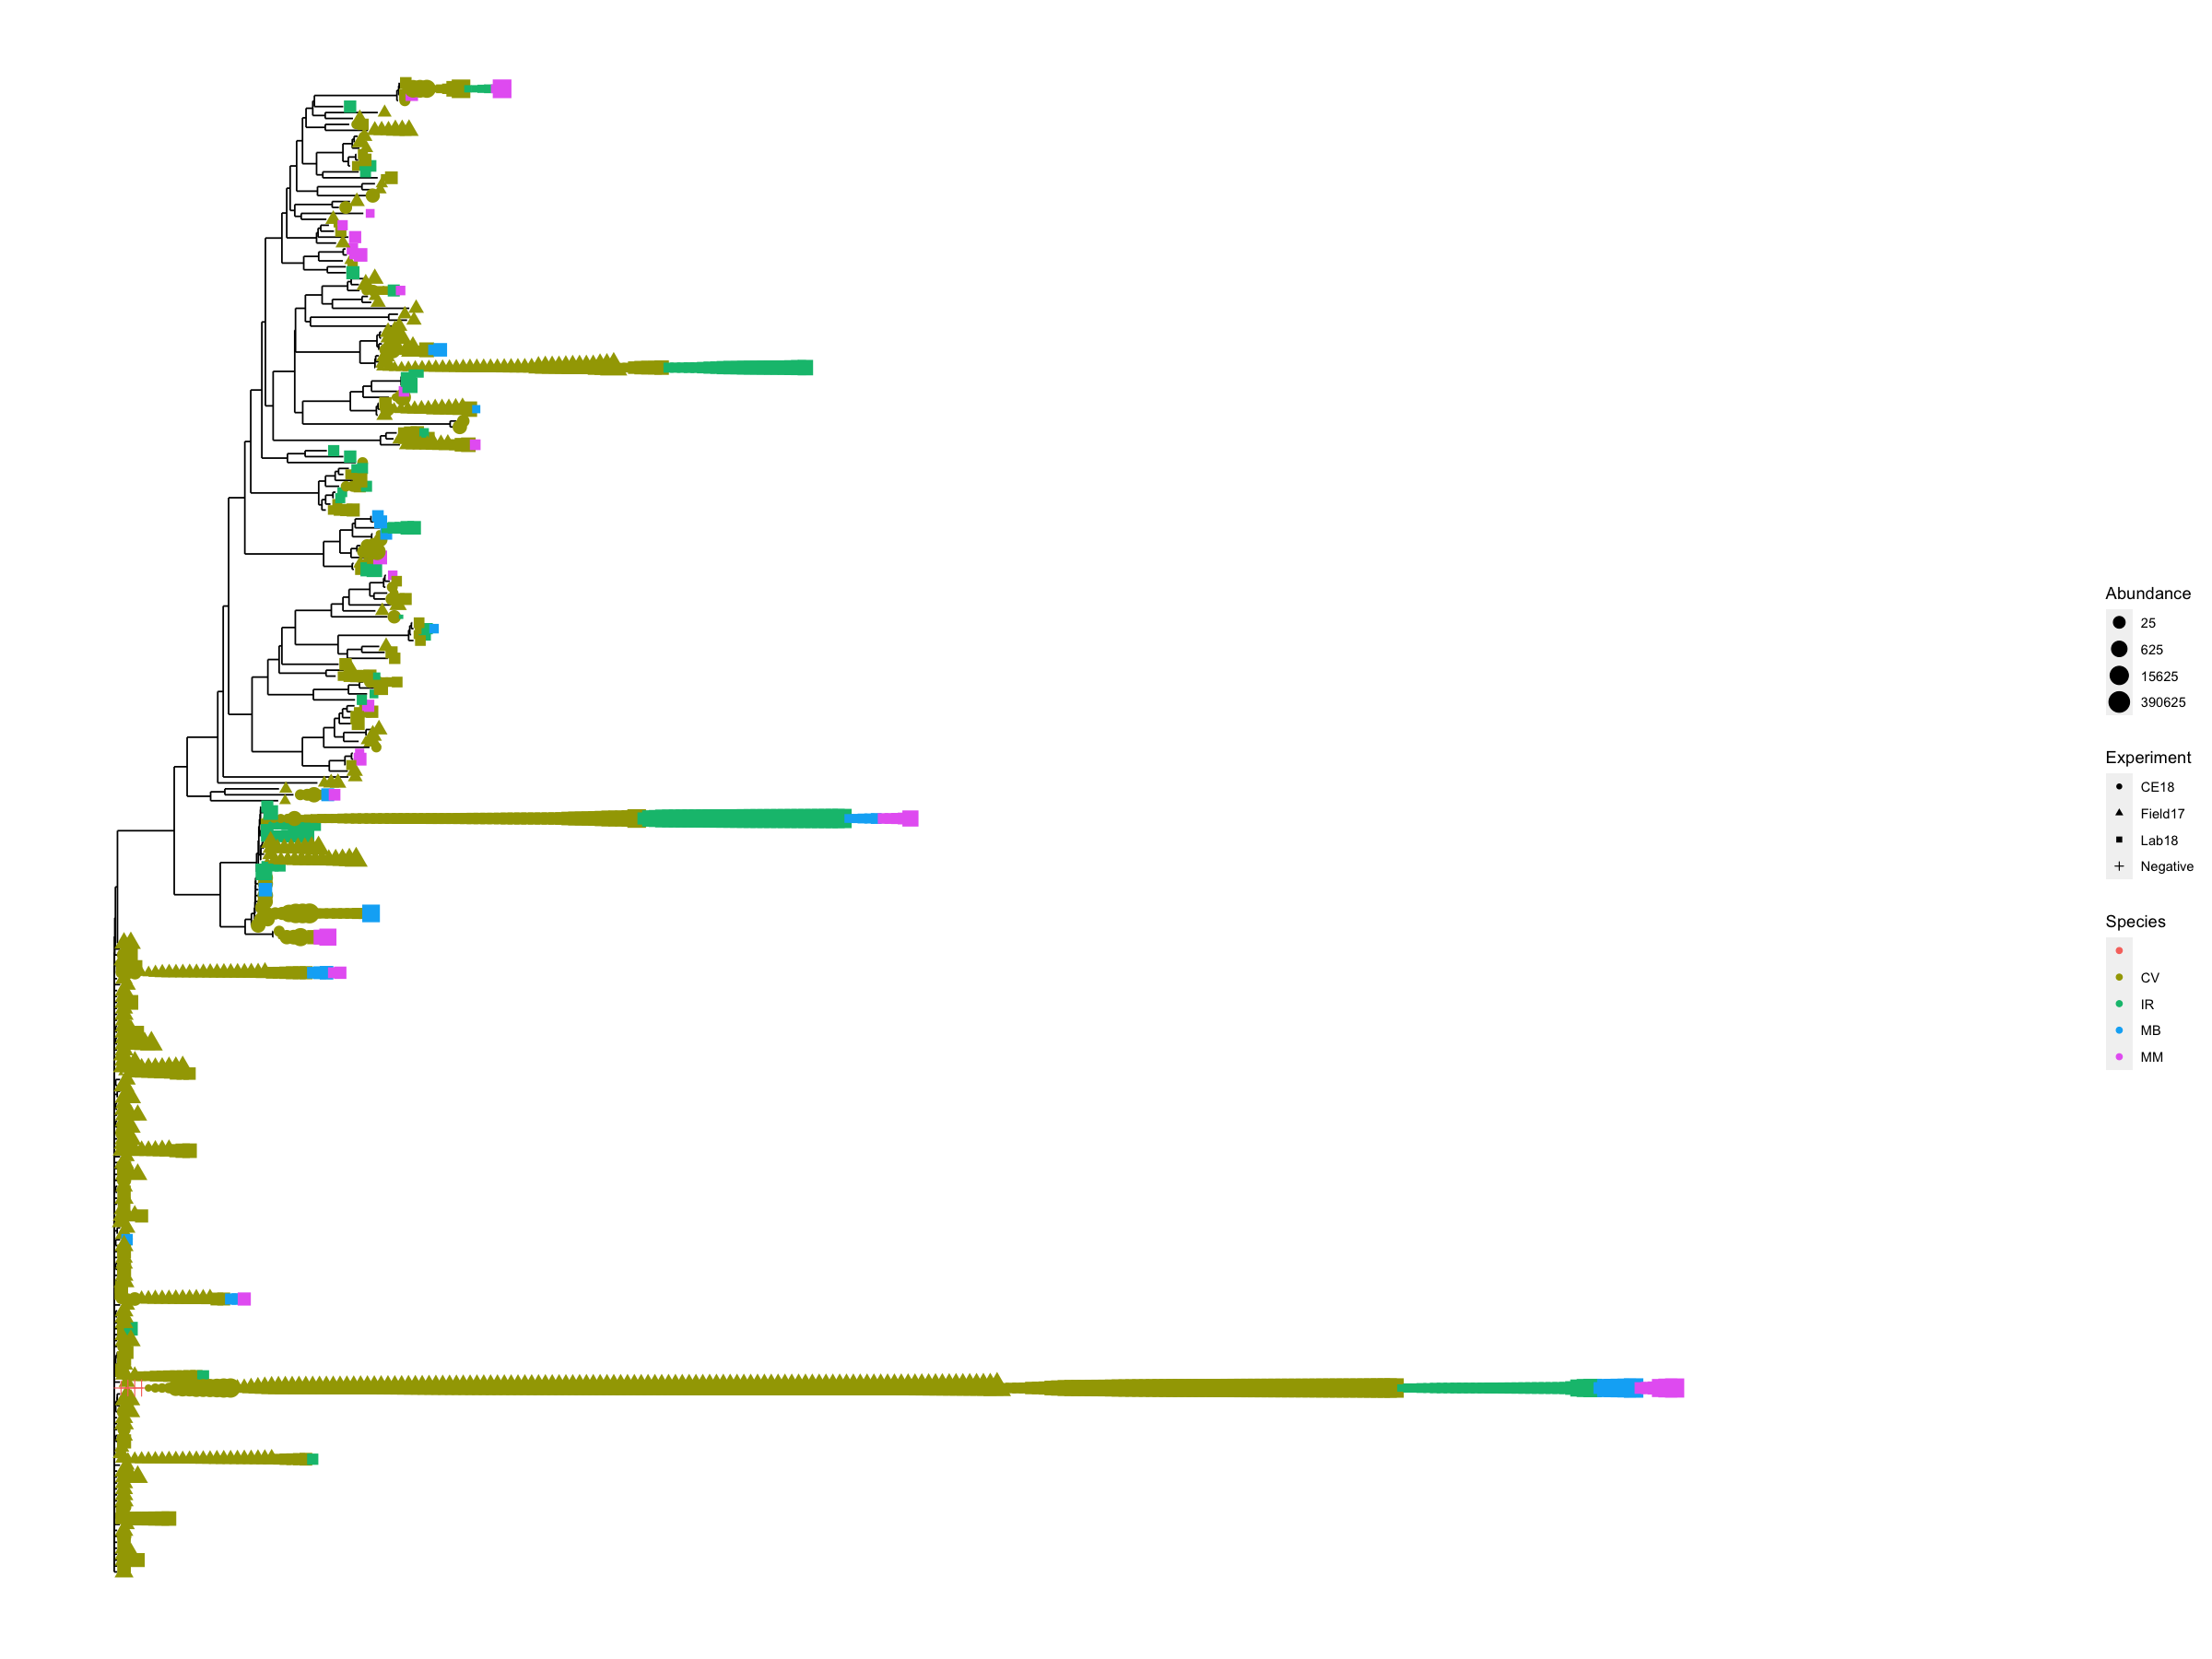

In [81]:
plot_tree(Spiro, color = "Species", shape = "Experiment", ladderize="left", size="abundance")